# Force curves versus velocity for an $F_1 \rightarrow F_1$ system
In this notebook, we simulate cooling for an $F_1 \rightarrow F_1$ system. In particular, we reproduce figures from [NJP 18, 123017 (2016)](https://doi.org/10.1088/1367-2630/18/12/123017).

In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue
;

┌ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
└ @ Base loading.jl:1662
┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1662


We'll first define a few physical constants needed for this simulation. 

In [3]:
λ = 1; Γ = 2π; m = 1; k = 2π / λ;

Using `QuantumStates`, we can create both the ground states (`F1_lower`) and excited states (`F1_upper`) using the `AngularMomentumState` type, which is a state type of "bare" angular momentum states $|F,m\rangle$.

In [1851]:
F_lower = 1
F_upper = 2
QN_bounds = (E = 0.0, F = F_lower)
F1_lower = enumerate_states(AngularMomentumState, QN_bounds)
QN_bounds = (E = 1.0, F = F_upper)
F1_upper = enumerate_states(AngularMomentumState, QN_bounds)

ground_states = F1_lower
excited_states = F1_upper
states = [ground_states; excited_states]
;

The transition dipole moments `d` and the magnetic moments `d_m` are calculated using `QuantumStates.get_tdms_two_bases`:

In [1852]:
d_ge = get_tdms_two_bases(ground_states, excited_states, TDM)
d = zeros(length(states), length(states), 3)
d[1:length(ground_states), (length(ground_states)+1):length(states), :] .= d_ge
d[(length(ground_states)+1):length(states), 1:length(ground_states), :] .= permutedims(d_ge, (2,1,3))
;

In [1853]:
d .*= sqrt(2*F_upper + 1) / sqrt(2*F_lower + 1)

8×8×3 Array{Float64, 3}:
[:, :, 1] =
  0.0   0.0        0.0       -1.0  -0.0       -0.0       -0.0  -0.0
  0.0   0.0        0.0        0.0  -0.707107   0.0        0.0   0.0
  0.0   0.0        0.0       -0.0  -0.0       -0.408248  -0.0  -0.0
 -1.0   0.0       -0.0        0.0   0.0        0.0        0.0   0.0
 -0.0  -0.707107  -0.0        0.0   0.0        0.0        0.0   0.0
 -0.0   0.0       -0.408248   0.0   0.0        0.0        0.0   0.0
 -0.0   0.0       -0.0        0.0   0.0        0.0        0.0   0.0
 -0.0   0.0       -0.0        0.0   0.0        0.0        0.0   0.0

[:, :, 2] =
  0.0        0.0        0.0        0.0  -0.707107   0.0        0.0        0.0
  0.0        0.0        0.0       -0.0  -0.0       -0.816497  -0.0       -0.0
  0.0        0.0        0.0        0.0   0.0        0.0       -0.707107   0.0
  0.0       -0.0        0.0        0.0   0.0        0.0        0.0        0.0
 -0.707107  -0.0        0.0        0.0   0.0        0.0        0.0        0.0
  0.0       -0.8

In [1940]:
sum(d.^2, dims=[2,3])

8×1×1 Array{Float64, 3}:
[:, :, 1] =
 1.6666666666666667
 1.666666666666667
 1.6666666666666667
 1.0
 1.0000000000000002
 0.9999999999999999
 1.0000000000000002
 1.0

We now define the lasers, along with the detuning $\Delta$ and saturation $s$. Note that all lasers have the polarization $\sigma^+$ in their own frame, which is rotated to the $\hat{z}$ axis using `rotate_pol`. (Technically, the rotation is performed _from_ the $\hat{z}$ axis _to_ the axis of the given laser's $k$-vector because the variable $\sigma^+$ is defined relative to the $\hat{z}$ axis.)

In [1941]:
# Laser parameters
Δ = -2.5Γ
s = 1.0

# Frequency of the lasers (in angular frequency units)
ω_F1_to_F1 = 2π * (F1_upper[1].E - F1_lower[1].E) + Δ

ϵ_(ϵ1) = t -> ϵ1

ϕ = π/8

lin = cart2sph * [1,0,0]
linϕ = cart2sph * [cos(ϕ), sin(ϕ), 0]
lin_z = [0,1,0]

# k̂ = +x̂; ϵ1 = ϵ_(cart2sph * [0,1,0]); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(cart2sph * [0,0,1]); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(cart2sph * [1,0,0]); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(cart2sph * [0,0,1]); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(cart2sph * lin ); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(cart2sph * linϕ); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# xp_ϵ = cart2sph * [0, -im, -1] / √2
# xm_ϵ = cart2sph * [0, -im, +1] / √2
# yp_ϵ = cart2sph * [-1, 0, -im] / √2
# ym_ϵ = cart2sph * [+1, 0, -im] / √2
# zp_ϵ = cart2sph * [-1, -im, 0] / √2
# zm_ϵ = cart2sph * [+1, -im, 0] / √2

# k̂ = +x̂; ϵ1 = ϵ_(xp_ϵ); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(xm_ϵ); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(yp_ϵ); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(ym_ϵ); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
k̂ = -x̂; ϵ2 = ϵ_(-rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
k̂ = +ŷ; ϵ3 = ϵ_( rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
k̂ = -ŷ; ϵ4 = ϵ_(-rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
# lasers =  [laser3, laser4]
# lasers =  [laser5, laser6]
;

Before computing the force across a range of velocities, let's first check that our simulation produces reasonable results for a specific set of parameters:

In [1942]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-2

p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 20p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [1943]:
callback = PeriodicCallback(reset_force!, prob.p.period)

# prob.p.r0 = (0.4, 5e-9, 0.3) .* 2π
prob.p.v = (0.0, 0.1, 0.0)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), abstol=1e-5, callback=callback)
;

  8.480857 seconds (16.08 M allocations: 1.851 GiB, 6.32% gc time, 99.63% compilation time)


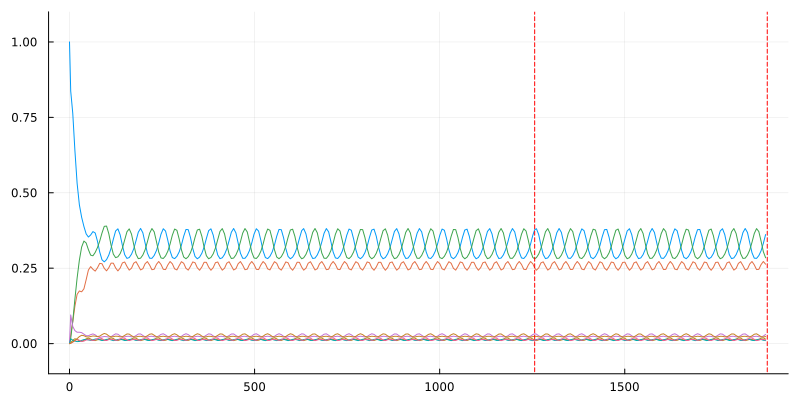

In [1944]:
using Plots
plot_us = sol.u[1:10:end]
plot_ts = sol.t[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

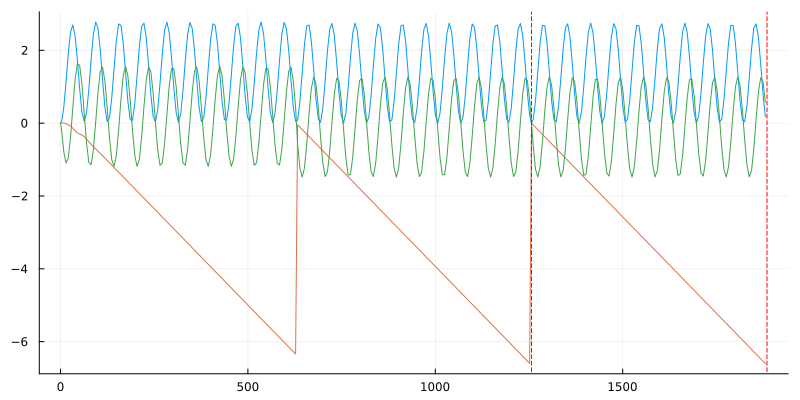

In [1945]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [1946]:
# E_test(x,y,z) = √2 .* [sin(k * z) - cos(k * y), sin(k * x) - cos(k * z), sin(k * y) - cos(k * x)] .* cos(p.fields.ω[1] * t_end)
E_test(x,y,z) = √2 .* [sin(z) - cos(y), sin(x) - cos(z), sin(y) - cos(x)] .* cos(p.fields.ω[1] * t_end)
# E_test(x,y,z) = √2 .* [sin(z), - cos(z), 0] .* cos(p.fields.ω[1] * t_end)

E_test (generic function with 1 method)

In [1947]:
idxs = 2000
1e3 * mean([u[end-2:end] for u ∈ sol.u[end-idxs:end]]) / (sol.t[end] - sol.t[end-idxs])

3-element Vector{ComplexF64}:
   0.7020218854101528 + 0.0im
  -1.7540239509194755 + 0.0im
 -0.04275143159725605 + 0.0im

In [1948]:
prob.p.force_last_period .* 1e3

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -9.696495371148176e-8
 -6.647467377547197
  9.570488357722635e-5

## Laser cooling force versus velocity

In [1949]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

In [1950]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i]) #(0, 0, scan_params.v[i]) #sample_direction(scan_params.v[i]) # (scan_params.v[i], 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
    # return round(norm(prob.p.v), digits=2)
end
function output_func(p, sol)
    f = p.force_last_period
    return f ⋅ p.v / norm(p.v)
end
;

In [1951]:
freq_res = 1e-3
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 100p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

n_samples = 50
# vs = repeat(collect(0:0.0025:0.1), n_samples)
# vs = repeat(collect(0:0.1:5.0), n_samples)
vs = repeat(collect(0:0.05:1.0), n_samples)
scan_params = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 14.166602 seconds (3.02 M allocations: 192.966 MiB, 0.26% gc time, 13.96% compilation time)


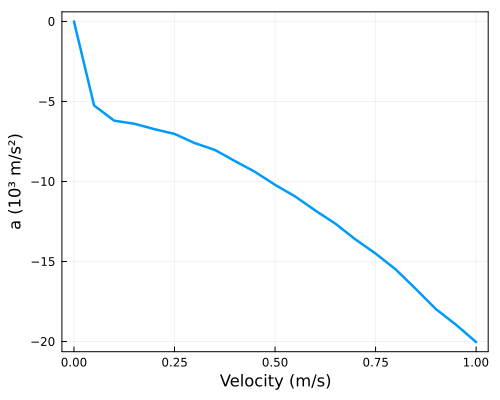

In [1952]:
@time scan_values, forces = force_scan(prob, scan_params, prob_func!, param_func, output_func);

vs, averaged_forces = average_forces(scan_values, forces)
averaged_forces[1] = 0.0
plot(vs, averaged_forces .* 1e3,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    # ylim=(-6,6),
    # ylim=(-70,20),
    size=(500,400),
    legend=nothing)

## Laser cooling force versus magnetic field

In [338]:
function prob_func!(p, scan_values, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_values.vs[i])
    p.r0 .= rand(uniform_dist, 3)
    # Round `v` to ensure that the OBEs are periodic
    p.v .= round_vel(p.v, p.freq_res)
    p.B .= (0.0, 0.0, scan_values.Bz[i])
    prob
end
function param_func(p, scan_values, i)
    return p.B[3]
end
function output_func(p, sol)
    f = p.force_last_period[3]
    # return f ⋅ p.v / norm(p.v)
    return f
end
;

In [ ]:
p = obe(ρ0, particle, states, lasers, d, d_m, true, true, λ, Γ, freq_res, nothing)
ODEProblem(ρ!, p.ρ0_vec, tspan, p, save_on=false)

n_samples = 200

Bzs = (0:0.1:2.0) ./ (2π)
vs  = 0.1 .* ones(length(Bzs))
scan_values = (Bz = repeat(Bzs, n_samples), vs = repeat(vs, n_samples))

@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress:   0%|█                                        |  ETA: 17:36:35┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Christian Hallas\.julia\packages\SciMLBase\ZGRni\src\integrator_interface.jl:502
Progress:   0%|█                                        |  ETA: 18:32:15┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Christian Hallas\.julia\packages\SciMLBase\ZGRni\src\integrator_interface.jl:502


In [ ]:
using LaTeXStrings
Bzs, averaged_forces = average_forces(scan_params, forces)
plot(Bzs .* (2π), 1e3 * averaged_forces, 
    xlabel="Magnetic field along z (ħΓ/μ)",
    ylabel="z force (10⁻³ ħkΓ)",
    legend=nothing, 
    linewidth=2)